# 1. A/B–тестирование

## 1.1 Условие
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы
целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы
оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## 1.2 Входные данные
В качестве входных данных Вы имеете 3 csv-файла:
- groups.csv : файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
- active_studs.csv : файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
- checks.csv : файл с информацией об оплатах пользователей в дни проведения эксперимента.

## 1.3 Вопросы
Предлагаем Вам ответить на следующие вопросы:
- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на
собственный план.

## 1.4 Требования к ответу
- При выполнении тестового задания необходимо использовать язык программирования Python.
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.


In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

warnings.filterwarnings('ignore')

Загрузим и изучим данные из таблиц.

In [2]:
data_groups = pd.read_csv('datasets/groups.csv', sep=';')
data_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [3]:
data_active_studs = pd.read_csv('datasets/active_studs.csv', sep=';')
data_active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [4]:
data_checks = pd.read_csv('datasets/checks.csv', sep=';')
data_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Оценим разделение пользователей на группы A/B теста.

In [5]:
all_members_count = data_groups['grp'].value_counts()
all_members_count

B    59883
A    14693
Name: grp, dtype: int64

Выделим из data_groups пользователей, которые проявили активность в дни эксперимента.

In [6]:
active_studs_id = data_active_studs['student_id']
active_members = data_groups.query('id in @active_studs_id')
active_members_count = active_members['grp'].value_counts()
active_members_count

B    6803
A    1538
Name: grp, dtype: int64

Выделим из active_members пользователей, которые совершали покупки во время эксперимента.

In [7]:
customer_studs_id = data_checks['student_id']
customer_members = active_members.query('id in @customer_studs_id')
customer_members_count = customer_members['grp'].value_counts()
customer_members_count

B    314
A     78
Name: grp, dtype: int64

Добавим в data_checks данные по группе для аггрегации

In [8]:
customer_members = customer_members.sort_values(by='id').reset_index(drop=True)
data_checks['grp'] = customer_members['grp']
data_checks.head()

,student_id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B


Проведем аггрегацию в data_checks по столбцу grp, чтобы найти сумму покупок на группу и среднее значение покупки на пользователя. 

In [9]:
payment_data = data_checks.pivot_table(index='grp', values='rev', aggfunc=['sum', 'mean'])
payment_data.columns = ['sum_rev', 'mean_rev']
payment_data

,sum_rev,mean_rev
grp,,
A,87794.0003,1125.564106
B,348357.0026,1109.417206


Соберем данные в одну таблицу ab_test_data.

In [10]:
ab_test_data = pd.concat([all_members_count,active_members_count,customer_members_count, payment_data], axis=1)
ab_test_data.columns=['all_members_count',
                      'active_members_count',
                      'customer_members_count',
                      'sum_rev',
                      'mean_rev']
ab_test_data['sum_rev'] = ab_test_data['sum_rev'].round()
ab_test_data['mean_rev'] = ab_test_data['mean_rev'].round(2)
ab_test_data['engagement_ratio'] = (ab_test_data['active_members_count']/ab_test_data['all_members_count']).round(3)
ab_test_data['conversion_ratio'] = (ab_test_data['customer_members_count']/ab_test_data['active_members_count']).round(3)
ab_test_data

,all_members_count,active_members_count,customer_members_count,sum_rev,mean_rev,engagement_ratio,conversion_ratio
B,59883,6803,314,348357.0,1109.42,0.114,0.046
A,14693,1538,78,87794.0,1125.56,0.105,0.051


##### Ответ на вопрос. На какие метрики Вы смотрите в ходе анализа и почему?

Пояснение к таблице:

- all_members_count - количество всех участников в тестовых группах. Позволяет узнать размер аудитории сайта.
- active_members_count - количество участников в тестовых группах, которые попали в эксперимент. Определяет, сколько удалось охватить пользователей для проведения теста.
- customer_members_count - количество участников в тестовых группах, которые попали в эксперимент и приобрели услугу. Напрямую отображают прибыль от услуг.
- sum_rev - сумма покупок в тестовых группах. Показывает, сколько удалось получить от каждой группы пользователей.
- mean_rev - средняя сумма покупки на человека в тестовых группах. Показывает в общем сумму, который готов отдать человек за услугу.
- engagement_ratio - процент вовлечения участников в эксперимент в тестовых группах. Какая часть всех пользователей попала в эксперимент.
- conversion_ratio - процент конверсии в тестовых группах. Ключевой показатель, говорящий об эффективости механик.

In [11]:
print("Процент вовлечения пользователей в эксперимент =",
      ab_test_data['active_members_count'].sum()/ab_test_data['all_members_count'].sum())

Процент вовлечения пользователей в эксперимент = 0.11184563398412357


##### Ответ на вопрос. Имеются ли различия в показателях и с чем они могут быть связаны?

Основными показатели, которые помогут понять результативность A/B теста это:
1. Процент конверсии в тестовых группах (conversion_ratio).
2. Процент вовлечения участников в эксперимент в тестовых группах (engagement_ratio) и общий процент вовлечения пользователей.
3. Cредняя сумма покупки на человека в тестовых группах(mean_rev).

Разница процента конверсии между группой B = 4.6% и A = 5.1% незначительна, но это дает понимание, что новая механика повлияла отрицательно на решение о покупке услуги. 

A/B тест был проведен на 11.1% пользователей. Больше пользователей выпало на группу В (11.4%) по сравнению с группой A (10.5%). 
При суммарном количестве в 8300 человек можно сказать, что A/B тест также себя покажет и при большем количестве данных. Кроме того, этого количесва пользователей достаточно, чтобы считать эксперимент адекватным.

Средняя сумма покупки между пользователями групп A и B не сильно отличаются. Это говорит нам, что новая механика оплаты не повлияла на покупаемые услуги в целом. Пользователи группы A покупают тоже самое, что и пользователи группы В. 

##### Ответ на вопрос. Являются ли эти различия статистически значимыми?

Проведем оценку статистической значимости разницы данных.

Создадим таблицу conversion_data, где отразим, сколько пользователей оплатили услугу и отказались от нее. 

In [12]:
conversion_data = ab_test_data[['active_members_count', 'customer_members_count']]
conversion_data = conversion_data.sort_values(by='active_members_count', ascending=True)
conversion_data

,active_members_count,customer_members_count
A,1538,78
B,6803,314


Преобразуем столбец active_members_count в non_customer_members_count, где рассчитаем, сколько пользователей не преобрели услугу.

In [13]:
conversion_data['active_members_count'] = conversion_data['active_members_count'] - conversion_data['customer_members_count']
conversion_data.columns = ['non_customer_members_count', 'customer_members_count']
conversion_data

,non_customer_members_count,customer_members_count
A,1460,78
B,6489,314


В качестве критерия значимости A/B теста будем использовать тест Пирсона по хи-квадрату. 

Нулевая гипотеза гласит: "Разница показателей оплаты услуги по новой механике и по старой механике статистически значима".<br>
Альтернативная гипотеза гласит: "Разница показателей оплаты услуги по новой механике и по старой механике статистически незначима".

In [14]:
pvalue= st.chi2_contingency(conversion_data.values, correction=False)[1]

# Интерпретация p-величины
prob = 0.95
alpha = 1.0 - prob
print('Значимость=%.3f, p-величина=%.3f' % (alpha, pvalue))
if pvalue <= alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Невозможно отвергнуть нулевую гипотезу')

Значимость=0.050, p-величина=0.445
Невозможно отвергнуть нулевую гипотезу


Различия в поведении пользователей в группах A и В статистически значимы.

##### Ответ на вопрос. Стоит ли запускать новую механику на всех пользователей?

Рекомендую не вводить новую механику для всех пользователей.

Показатели тестовой группы в малой степени отличаются от показателей контрольной группы. Снижение приобретаемых услуг и уменьшение чека возможно говорит о том, что новый процесс оплаты услуг неудобен конечному пользователю. Влияние новой механики как минимум негативно сказывается на покупках, а как макимум не отличается от старого способа оплаты.

Необходимо провести тест на большем количестве данных - увеличение охвата пользователей в 2 или 3 раза. 
Или изменение новой механики и повторное применние эксперимента. 


# 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы на uchi.ru состоят из различных уроков, каждый из которых состоит
из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц
правильно решил 20 горошин за час.

### 2.1.2 Задача
Дана таблица peas:

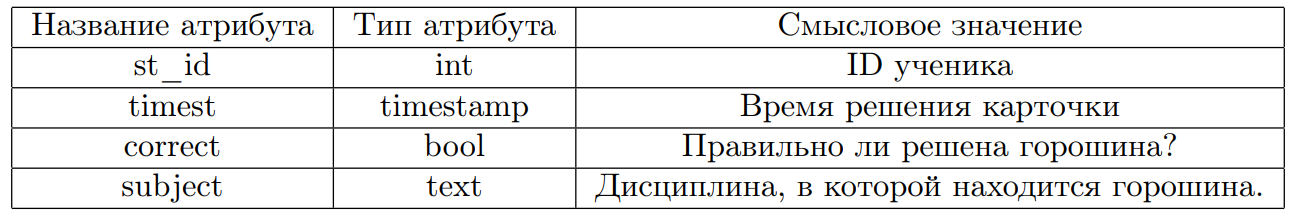

Необходимо написать оптимальный запрос, который даст информацию о количестве очень
усердных студентов за март 2020 года

### SQL-запрос на PostgreSQL

``` MySQL
SELECT
    COUNT(DISTINCT st_id) as cnt_st
FROM
(SELECT
    st_id,
    DATE_TRUNC('hour',timest) as hour_timest,
    COUNT(date_trunc('hour',timest)) as count_peans
FROM
    peas
WHERE
    (timest BETWEEN '2020-03-01' AND '2020-03-31') 
    and correct = true 
GROUP BY
    st_id, hour_timest
HAVING
    count(date_trunc('hour',timest)) >= 20) as peas_march20```

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Uchi.ru предлагает пройти студентам курсы по модели trial: студент может решить бесплатно
лишь 30 горошин в день. Для неограниченного количества заданий в определённой дисциплине
студенту необходимо приобрести полный доступ. Команда uchi.ru провела эксперимент, где был
протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

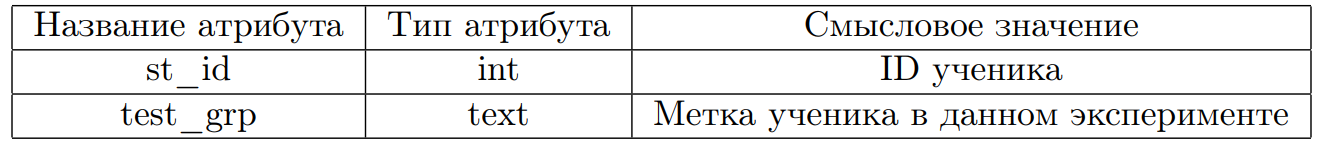

и checks:

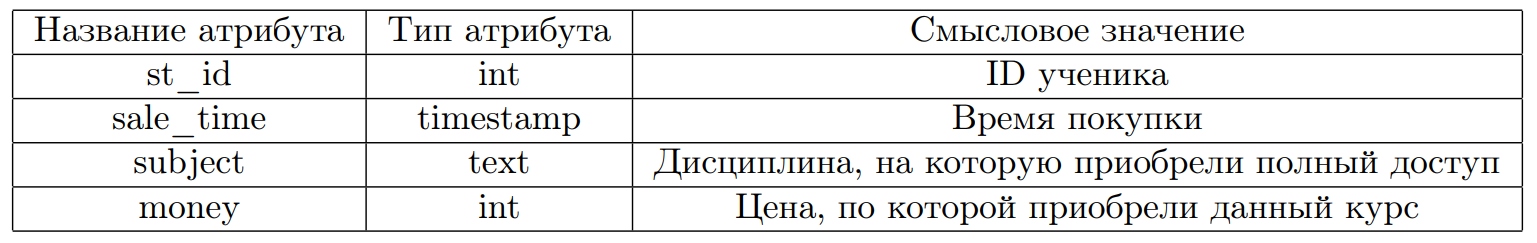

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
1. ARPU
2. ARPAU
3. CR в покупку
4. СR активного пользователя в покупку
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Пояснение метрик к данной задаче:

1. Average revenue per user, средняя выручка на одного пользователя. Под пользователями понимают всех пользователей, зарегистрированных на сайте.
2. Average revenue per active user, средняя выручка на одного активного пользователя. Под активным пользователем понимают пользователя, который пользуется сайтом.
3. Conversion rate или процент конвертации в покупку
4. Conversion rate или процент конвертации активного пользователя в покупку
5. Conversion rate или процент конвертации пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Отличать активных пользователей будем по наличию записи в таблице peas.
Все пользователи находяться в таблице studs.

### SQL-запрос на PostgreSQL

``` MySQL
WITH 
    student_data as(
        SELECT
           1 as index,
           COUNT(st_id) as st_cnt
        FROM
            studs),
    active_student_data as(
        SELECT
           1 as index,
           COUNT(DISTINCT st_id) as a_st_cnt,
           COUNT(DISTINCT st_id) filter (where subject='math') as a_st_cnt_math
        FROM
            peas),
    payment_data as(
        SELECT
           1 as index,
           SUM(money) as payment_sum,
           COUNT(DISTINCT st_id) as payment_cnt,
           COUNT(DISTINCT st_id) filter (where subject='math') as payment_cnt_math
        FROM
            checks)
SELECT 
    payment_sum/st_cnt::real as ARPU,
    payment_sum/a_st_cnt::real as ARPAU,
    payment_cnt/st_cnt::real as CRPU,
    payment_cnt/a_st_cnt::real as CRPAU,
    payment_cnt_math/a_st_cnt_math::real as CRPAU_for_math
FROM 
    payment_data
JOIN student_data ON student_data.index=payment_data.index
JOIN active_student_data ON active_student_data.index=payment_data.index
```

# 3. Python

## 3.1 Задача

1. Создайте класс BaseGraph со следующими атрибутами:
    - Источник данных (pandas.DataFrame или csv)
    - Название графика
    - Подписи осей
    - Другие параметры, которые, возможно, захочет увидеть пользователь
2. Создайте метод plot, который будет строить line graph.
3. Создайте класс BarGraph, который будет наследником класса BaseGraph. Переопределите метод plot, который будет адаптирован для построения bar chart.
4. Проиллюстрируйте работу написанных классов на собственных примерах, проверив, что Ваш класс корректно обрабатывает все краевые случаи.

In [15]:
class BaseGraph:
 
    def __init__(self, 
                 data, 
                 title='Here is a place for Title', 
                 labels=['Here is a place for X label', 'Here is a place for Y label'], 
                 grid=False, 
                 color='red', 
                 figsize=(8, 6)):
        self.data = data
        self.title = title
        self.labels = labels
        self.grid = grid
        self.color = color
        self.figsize = figsize
    
    def plot(self):
        plt.figure(figsize=self.figsize)
        plt.plot(self.data, color=self.color)
        plt.title(self.title)
        plt.xlabel(self.labels[0])
        plt.ylabel(self.labels[1])
        plt.grid(self.grid)
        plt.show()

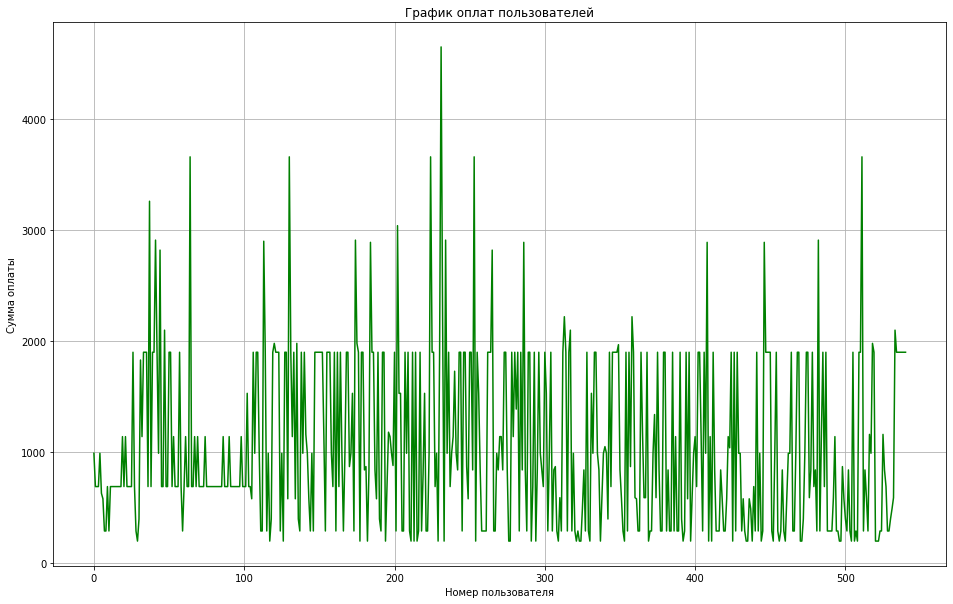

In [16]:
bg = BaseGraph(data_checks['rev'], 'График оплат пользователей', ['Номер пользователя', 'Сумма оплаты'], True, 'green', (16,10))
bg.plot()

In [17]:
class BarGraph(BaseGraph):
    
    def plot(self):
        fig =plt.figure(figsize=self.figsize)
        ax = fig.add_axes([0,0,1,1])
        ax.bar(self.data.index, self.data[self.data.columns[0]])
        plt.title(self.title)
        plt.xlabel(self.labels[0])
        plt.ylabel(self.labels[1])
        plt.grid(self.grid)
        plt.show()

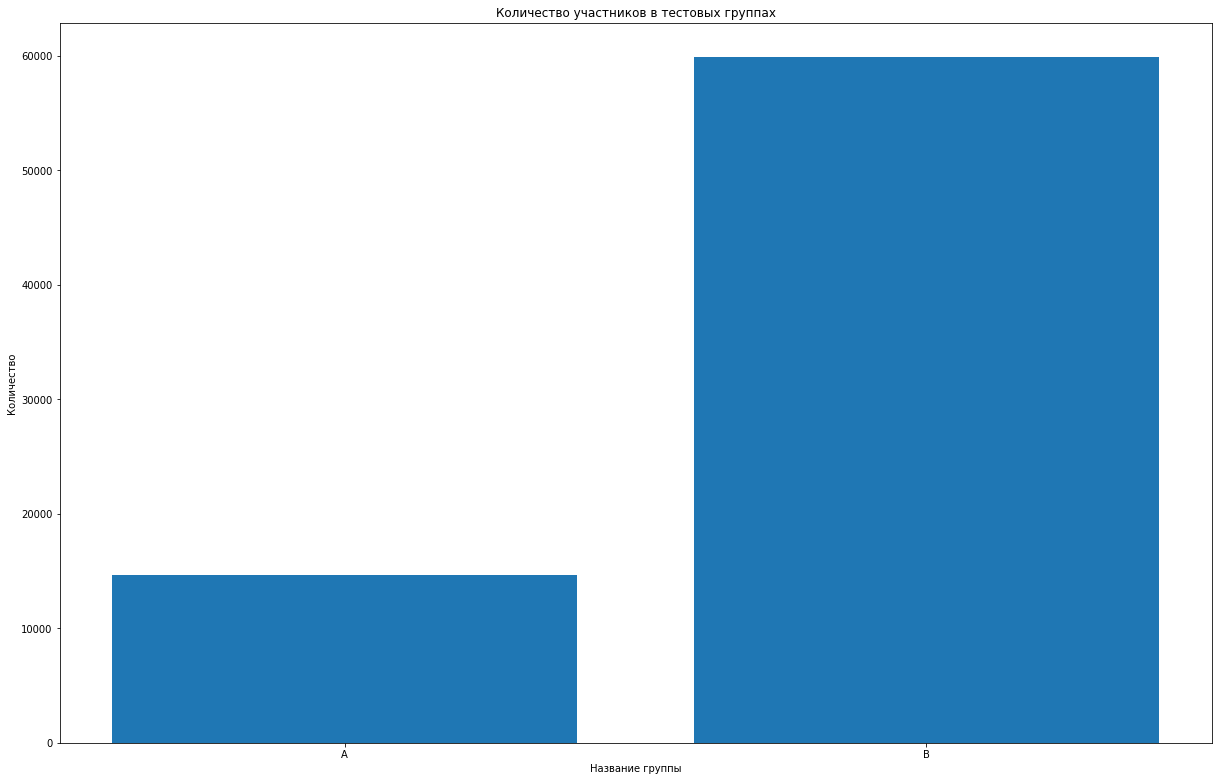

In [18]:
data = data_groups.groupby('grp').count()
bg = BarGraph(data, 'Количество участников в тестовых группах', ['Название группы', 'Количество'], figsize=(16, 10))
bg.plot()